# What this note can do?

NOTE: we creaed original imput files by Extract_nongap-sites_on_HXB2_Rhesus_DNA.ipynb, which can be found at /Users/kais/Documents/CODE/HMMER_HIV/note/

- Table of index and mutation strength. 
- From this CSV file, determin Abs resitance mutation. 

In [1]:
#Pkg.add("Pkg"); import Pkg; 
using Pkg
using Distributed
using DelimitedFiles
using Profile    
using Random
using Statistics
using LinearAlgebra
using Plots
using Printf
using Measures
using CSV
using LaTeXStrings;
using DataFrames
rng = Random.MersenneTwister(1234);

In [2]:
include("../src/basic_MPL.jl");
include("../src/basic.jl")
include("../src/my_HIV_data_cleanign.jl")
include("../src/basic_analysis.jl")
include("../src/non_synonymous_N-glycan.jl") 
include("../src/process_HIV_mutation_for_CSV.jl") 
NUC = ["-", "A", "C", "G", "T"];

# Processes Start

## Retrieve variable and antibody binding sites 

In [4]:
# Keep trucking only the following sites and nucleotides;
# Should include also HXB2 inde for protein and genes. 
hxb2csv = DataFrame(CSV.File("../data/csv/hxb2.csv"));
csv_raw_CH103binding = DataFrame(CSV.File("../data/csv/CH103_binding.csv"))
csv_raw_CH235binding = DataFrame(CSV.File("../data/csv/CH235_binding.csv"))
csv_raw_CD4contact = DataFrame(CSV.File("../data/csv/CD4_contct_residue.csv"))
csv_raw_V1_HV = DataFrame(CSV.File("../data/csv/V1_Hypervariable_residue.csv"))
csv_raw_V2_HV = DataFrame(CSV.File("../data/csv/V2_Hypervariable_residue.csv"))
csv_raw_V3_HV = DataFrame(CSV.File("../data/csv/V3_Hypervariable_residue.csv"))
csv_raw_V4_HV = DataFrame(CSV.File("../data/csv/V4_Hypervariable_residue.csv"))
csv_raw_V5_HV = DataFrame(CSV.File("../data/csv/V5_Hypervariable_residue.csv"))
csv_raw_LoopD = DataFrame(CSV.File("../data/csv/Loop-D_residue.csv"));

csv_raw_resist_mut_CH103 = DataFrame(CSV.File("../data/csv/resistant_mut_to_CH103.csv")) 
csv_raw_resist_mut_CH235 = DataFrame(CSV.File("../data/csv/resistant_mut_to_CH235.csv")) 
csv_raw_resist_strain_specific_Abs_CH505 = DataFrame(CSV.File("../data/csv/resistant_mut_to_strain_specific-bnAbs_CH505.csv")) 
csv_raw_common_mut_SHIV_CH505 = DataFrame(CSV.File("../data/csv/common_mutation_rhesus_SHIV505.csv")) ;

## Formatting the files

In [5]:
csv_selection = DataFrame(CSV.File("../data/mpl/703010505-3-poly.csv"));

gene_set = [[] for _ in 1:3]; vec_AA_idx = [[] for _ in 1:3]; HXB2_set = [[] for _ in 1:3]; 
vec_nuc_idx = []; frame_set = []; 
for x in csv_selection.HXB2_index
    num_nuc = get_num_nuc(x)
    frame, gene = index2frame(num_nuc)
    num_nuc, num_AA, gene = map_numNUC_to_numAA(x, frame)
    #@assert(gene==gene_check)
    
    push!(frame_set, frame)
    push!(vec_nuc_idx, num_nuc)
    for fr in 1:3 
        push!(gene_set[fr], gene[fr])
        push!(vec_AA_idx[fr], num_AA[fr])
        push!(HXB2_set[fr], HXB2(num_nuc, num_AA[fr], gene[fr]))
    end
end;

@printf("Fr.1: gene: %s\n", join(unique(gene_set[1]), ", "));
@printf("Fr.2: gene: %s\n", join(unique(gene_set[2]), ", "));
@printf("Fr.3: gene: %s\n", join(unique(gene_set[3]), ", "));
@printf("max: %d, %d\n", maximum(skipmissing(vec_nuc_idx)), maximum(skipmissing(vec_nuc_idx))) 
@printf("min: %d, %d\n", minimum(skipmissing(vec_nuc_idx)), minimum(skipmissing(vec_nuc_idx)));

# Use frame 3 where Env gene belongs. 
vec_CH103_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH103binding)
vec_CH235_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH235binding)
vec_CD4contact_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CD4contact)
vec_V1 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V1_HV)
vec_V2 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V2_HV)
vec_V3 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V3_HV)
vec_V4 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V4_HV)
vec_V5 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V5_HV)
vec_LoopD = get_true_false_variable_region(vec_AA_idx[3], csv_raw_LoopD);

# These are all waat I need. 
csv_index_and_TF= DataFrame(CSV.File("../data/mpl/703010505-3-index.csv"));
seq_num_raw = readdlm("../data/mpl/703010505-3-poly-seq2state.dat", Int);

Fr.1: gene: , tat
Fr.2: gene: vpu, , rev
Fr.3: gene: env
max: 8795, 8795


min: 6225, 6225


## Processes to get mutations 

In [11]:
# ---- Get mutations ------#
(mutant_hxb2, mutant_nuc, mutant_date_found, mutant_gene, mutant_types_set_AA, 
mutant_types_set_nuc, mutant_types_set_nuc_simple, plus_glycan_set, minus_glycan_set, shifted_glycan_set
) = Make_combination_of_mutations_with_genetic_background_w_glycan(csv_index_and_TF, seq_num_raw, hxb2csv); 
mutant_types_set_AA_filtered = []
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[1]));
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[2]));
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[3]));


mutant_types_set_TF_AA = get_TF_AA(csv_index_and_TF, mutant_hxb2) ;
mutant_types_set_AA_filtered_v2 = []
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[1], mutant_types_set_TF_AA[1]))
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[2], mutant_types_set_TF_AA[2]))
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[3], mutant_types_set_TF_AA[3]));


## Check the entories of resistant mutations

In [12]:
# Check the ordering is the same as the *-3-poly and *-3-index. 
for i in 1:length(csv_selection.HXB2_index)
    i_HXB2 = csv_selection.HXB2_index[i]
    i_HXB2_v2 = mutant_hxb2[i]
    nuc = csv_selection.nucleotide[i]
    nuc_v2 = mutant_nuc[i]
    @assert (i_HXB2 == i_HXB2_v2 && nuc == nuc_v2)
end

# --- Check whether mutations have been reported or not. ---# 
reported_mutant_data = copy(String.(csv_raw_resist_mut_CH103[:, 1]))
bool_resist_mut_CH103 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_resist_mut_CH235[:, 1]))
bool_resist_mut_CH235 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_resist_strain_specific_Abs_CH505[:, 1]))
bool_resist_strain_specific_Abs_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_common_mut_SHIV_CH505[:, 1]))
bool_common_mut_SHIV_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
reversion_true_false = csv_selection.consensus .== csv_selection.nucleotide .!= csv_selection.TF;

In [13]:
# --- Just filling basic information ----#
idx_sort_MPL = sortperm(csv_selection.s_MPL, rev=true);
idx = (mutant_types_set_nuc[3][idx_sort_MPL] .!= "") .* (mutant_date_found[idx_sort_MPL] .> 0)
df = DataFrame( HXB2=vec_nuc_idx[idx_sort_MPL][idx], )

df[!, "i_AA_fr1"]=replace_nothing_with_missing(vec_AA_idx[1])[idx_sort_MPL][idx]
df[!, "i_AA_fr2"]=replace_nothing_with_missing(vec_AA_idx[2])[idx_sort_MPL][idx]
df[!, "i_AA_fr3"]=replace_nothing_with_missing(vec_AA_idx[3])[idx_sort_MPL][idx]
df[!, "gene_fr1"]=replace_nothing_with_missing(gene_set[1])[idx_sort_MPL][idx]
df[!, "gene_fr2"]=replace_nothing_with_missing(gene_set[2])[idx_sort_MPL][idx]
df[!, "gene_fr3"]=replace_nothing_with_missing(gene_set[3])[idx_sort_MPL][idx]

# -- Just copying fields already in the *-3-poly.csv
for header_temp in names(csv_selection)
    if(!occursin(r"f_at", header_temp) && !occursin(r"epitope", header_temp))
        df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
    end
end
# --- Writing computed variables including types of mutaions ----#
df[!, "detected_date"] = mutant_date_found[idx_sort_MPL][idx]
df[!, "mutants_nuc"] = mutant_types_set_nuc_simple[3][idx_sort_MPL][idx]

df[!, "mutants_AA_fr1"] = mutant_types_set_AA_filtered_v2[1][idx_sort_MPL][idx]
df[!, "mutants_AA_fr2"] = mutant_types_set_AA_filtered_v2[2][idx_sort_MPL][idx]
df[!, "mutants_AA_fr3"] = mutant_types_set_AA_filtered_v2[3][idx_sort_MPL][idx]
df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr1"] = plus_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr1"] = minus_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr1"] = shifted_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr2"] = plus_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr2"] = minus_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr2"] = shifted_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr3"] = plus_glycan_set[3][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr3"] = minus_glycan_set[3][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr3"] = shifted_glycan_set[3][idx_sort_MPL][idx]

# -- Just copying single site trajectories *-3-poly.csv
for header_temp in names(csv_selection)
    if(occursin(r"f_at", header_temp) )
        df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
    end
end
CSV.write("../out/703010505-3-poly_sorted_with_mutant.csv", df); 

# CSV files for Rhesus Macaques

In [14]:
fname_key_RMs = ["RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];

In [15]:
for key_RM in fname_key_RMs
    @sprintf("%s\n", key_RM)
    csv_selection = DataFrame(CSV.File("../data/mpl/SHIV.CH505/" * key_RM * "-3-poly.csv"));

    gene_set = [[] for _ in 1:3]; vec_AA_idx = [[] for _ in 1:3]; HXB2_set = [[] for _ in 1:3]; 
    vec_nuc_idx = []; frame_set = []; 
    for x in csv_selection.HXB2_index
        num_nuc = get_num_nuc(x)
        frame, gene = index2frame(num_nuc)
        num_nuc, num_AA, gene = map_numNUC_to_numAA(x, frame)
        #@assert(gene==gene_check)

        push!(frame_set, frame)
        push!(vec_nuc_idx, num_nuc)
        for fr in 1:3 
            push!(gene_set[fr], gene[fr])
            push!(vec_AA_idx[fr], num_AA[fr])
            push!(HXB2_set[fr], HXB2(num_nuc, num_AA[fr], gene[fr]))
        end
    end;

    @printf("Fr.1: gene: %s\n", join(unique(gene_set[1]), ", "));
    @printf("Fr.2: gene: %s\n", join(unique(gene_set[2]), ", "));
    @printf("Fr.3: gene: %s\n", join(unique(gene_set[3]), ", "));
    @printf("max: %d, %d\n", maximum(skipmissing(vec_nuc_idx)), maximum(skipmissing(vec_nuc_idx))) 
    @printf("min: %d, %d\n", minimum(skipmissing(vec_nuc_idx)), minimum(skipmissing(vec_nuc_idx)));

    # Use frame 3 where Env gene belongs. 
    vec_CH103_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH103binding)
    vec_CH235_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH235binding)
    vec_CD4contact_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CD4contact)
    vec_V1 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V1_HV)
    vec_V2 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V2_HV)
    vec_V3 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V3_HV)
    vec_V4 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V4_HV)
    vec_V5 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V5_HV)
    vec_LoopD = get_true_false_variable_region(vec_AA_idx[3], csv_raw_LoopD);
    # ----------------------------------------------------------------#

    # These are all waat I need. 
    csv_index_and_TF= DataFrame(CSV.File("../data/mpl/SHIV.CH505/" *key_RM* "-3-index.csv"));
    seq_num_raw = readdlm("../data/mpl/SHIV.CH505/" *key_RM* "-3-poly-seq2state.dat", Int);

    # ---- Get mutations ------#
    (mutant_hxb2, mutant_nuc, mutant_date_found, mutant_gene, mutant_types_set_AA, 
    mutant_types_set_nuc, mutant_types_set_nuc_simple, plus_glycan_set, minus_glycan_set, shifted_glycan_set
    ) = Make_combination_of_mutations_with_genetic_background_w_glycan(csv_index_and_TF, seq_num_raw, hxb2csv); 
    mutant_types_set_AA_filtered = []
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[1]));
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[2]));
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[3]));

    # ----------------------------------------------------------------#
    for i in 1:length(csv_selection.HXB2_index)
        i_HXB2 = csv_selection.HXB2_index[i]
        i_HXB2_v2 = mutant_hxb2[i]
        nuc = csv_selection.nucleotide[i]
        nuc_v2 = mutant_nuc[i]
    end

    # --- Check whether mutations have been reported or not. ---# 
    reported_mutant_data = copy(String.(csv_raw_resist_mut_CH103[:, 1]))
    bool_resist_mut_CH103 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_resist_mut_CH235[:, 1]))
    bool_resist_mut_CH235 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_resist_strain_specific_Abs_CH505[:, 1]))
    bool_resist_strain_specific_Abs_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_common_mut_SHIV_CH505[:, 1]))
    bool_common_mut_SHIV_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
    reversion_true_false = csv_selection.consensus .== csv_selection.nucleotide .!= csv_selection.TF;
    
    # --- Just filling basic information ----#
    idx_sort_MPL = sortperm(csv_selection.s_MPL, rev=true);
    idx = (mutant_types_set_nuc[3][idx_sort_MPL] .!= "") .* (mutant_date_found[idx_sort_MPL] .> 0)
    df = DataFrame(HXB2=vec_nuc_idx[idx_sort_MPL][idx], )
    
    df[!, "i_AA_fr1"]=replace_nothing_with_missing(vec_AA_idx[1])[idx_sort_MPL][idx]
    df[!, "i_AA_fr2"]=replace_nothing_with_missing(vec_AA_idx[2])[idx_sort_MPL][idx]
    df[!, "i_AA_fr3"]=replace_nothing_with_missing(vec_AA_idx[3])[idx_sort_MPL][idx]
    df[!, "gene_fr1"]=replace_nothing_with_missing(gene_set[1])[idx_sort_MPL][idx]
    df[!, "gene_fr2"]=replace_nothing_with_missing(gene_set[2])[idx_sort_MPL][idx]
    df[!, "gene_fr3"]=replace_nothing_with_missing(gene_set[3])[idx_sort_MPL][idx]

    # -- Just copying fields already in the *-3-poly.csv
    for header_temp in names(csv_selection)
        if(!occursin(r"f_at", header_temp) && !occursin(r"epitope", header_temp))
            df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
        end
    end

    # --- Writing computed variables including types of mutaions ----#
    df[!, "detected_date"] = mutant_date_found[idx_sort_MPL][idx]
    df[!, "mutants_nuc_filtered"] = mutant_types_set_nuc_simple[3][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr1"] = mutant_types_set_AA_filtered[1][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr2"] = mutant_types_set_AA_filtered[2][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr3"] = mutant_types_set_AA_filtered[3][idx_sort_MPL][idx]
    df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
    df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
    df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
    df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
    df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
    df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
    df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
    df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
    df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
    df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
    df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
    df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
    df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
    df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr1"] = plus_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr1"] = minus_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr1"] = shifted_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr2"] = plus_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr2"] = minus_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr2"] = shifted_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr3"] = plus_glycan_set[3][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr3"] = minus_glycan_set[3][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr3"] = shifted_glycan_set[3][idx_sort_MPL][idx]
    
    # -- Just copying single site trajectories *-3-poly.csv
    for header_temp in names(csv_selection)
        if(occursin(r"f_at", header_temp) )
            df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
        end
    end

    CSV.write("../out/" *key_RM* "-3-poly_sorted_with_mutant.csv", df);
end

# Processes for Jointed Rhessu

In [57]:
f_dir = "../data/mpl/SHIV.CH505/"
csv_index_and_TF = DataFrame(CSV.File(f_dir * "Marged-RMs-index_with_poly_idx.csv"));
s_MPL_RMs = readdlm(f_dir * "RMs-poly-seq2state-MPL.dat")
s_SL_RMs = readdlm(f_dir * "RMs-poly-seq2state-SL.dat");
dx_RMs = readdlm(f_dir * "numerator-RMs-3-poly-seq2state.dat");
fname_key_RMs_and_Human = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];
n_max_RMs = length(fname_key_RMs_and_Human);

## Get processed mutations for jointed RMs for CSV file 
(polymorphic_index_global, HXB2_index_global, nucleotide_global, 
    TF_global, TF_global_RMs, nonsynonymous_global, nonsynonymous_global_RMs, 
    edge_gap_global, edge_gap_global_RMs, exposed_global, exposed_global_RMs, 
    flanking_global, flanking_global_RMs, glycan_global, glycan_global_RMs, consensus_global, consensus_global_RMs, 
    dx_marginalized, s_MPL_marginalized, s_SL_marginalized, s_MPL_global, s_SL_global) = get_csv_RMs(
    f_dir, csv_index_and_TF, s_MPL_RMs, s_SL_RMs, dx_RMs, fname_key_RMs_and_Human);

In [58]:
df = DataFrame( 
    polymorphic=polymorphic_index_global, 
    HXB2=HXB2_index_global, 
    nuc=nucleotide_global, 
    TF=TF_global, 
    TF_RMs=TF_global_RMs,
    nonsynonymous=nonsynonymous_global, 
    nonsynonymous_RMs=nonsynonymous_global_RMs, 
    consensus=consensus_global, 
    consensus_RMs=consensus_global_RMs,
    edge_gap=edge_gap_global, 
    edge_gap_RMs=edge_gap_global_RMs, 
    exposed=exposed_global, 
    exposed_RMs=exposed_global_RMs, 
    flanking=flanking_global, 
    flanking_RMs=flanking_global_RMs, 
    glycan=glycan_global, 
    glycan_RMs=glycan_global_RMs,  
)

df[:, "dx_RMs"] = dx_marginalized
df[:, "s_MPL_RMs"] = s_MPL_marginalized
for k in 1:n_max_RMs
    df[:, "s_MPL_"*fname_key_RMs_and_Human[k]] = s_MPL_global[k]
end
df[:, "s_SL_RMs"] = s_SL_marginalized
for k in 1:n_max_RMs
    df[:, "s_SL_"*fname_key_RMs_and_Human[k]] = s_SL_global[k]
end
CSV.write("../out/Marged-RMs-3-poly_SHIVCH505.csv", df);

## Normalizing selection coefficients 

In [59]:
csv_in = DataFrame(CSV.File("../out/Marged-RMs-3-poly_SHIVCH505.csv"));

polymorphic_unique = sort(unique(csv_in.polymorphic))
poly_max = maximum(polymorphic_unique)+1
s_mpl_TF = [0.0 for _ in 1:poly_max]
s_sl_TF = [0.0 for _ in 1:poly_max]
NA_list = [false for _ in 1:poly_max]
for x in polymorphic_unique
    tf_in = custom_mode(csv_in.TF_RMs[csv_in.polymorphic .== x])
    if(tf_in != "NA")
        idx1 = csv_in.polymorphic .== x
        idx2 = csv_in.nuc .== tf_in
        idx = idx1 .* idx2
        s_mpl_TF[x+1] = csv_in.s_MPL_RMs[idx][1]
        s_sl_TF[x+1] = csv_in.s_SL_RMs[idx][1]
        NA_list[x+1] = true
    end
end;

s_MPL_norm = []; s_SL_norm = []
for i in 1:length(csv_in.polymorphic)
    if( NA_list[ csv_in.polymorphic[i] + 1 ] )
        s_mpl_temp = csv_in.s_MPL_RMs[i] - s_mpl_TF[ csv_in.polymorphic[i] + 1 ]
        s_sl_temp = csv_in.s_SL_RMs[i] - s_sl_TF[ csv_in.polymorphic[i] + 1 ]
        push!(s_MPL_norm, s_mpl_temp)
        push!(s_SL_norm, s_sl_temp)
    else
        push!(s_MPL_norm, "NA")
        push!(s_SL_norm, "NA")
    end
end;

In [60]:
idx_non_NA = csv_in.TF_RMs .!= "NA"
df = DataFrame( 
    polymorphic=csv_in.polymorphic[idx_non_NA], 
    HXB2=csv_in.HXB2[idx_non_NA], 
    nuc=csv_in.nuc[idx_non_NA], 
    TF=csv_in.TF[idx_non_NA], 
    TF_RMs=csv_in.TF_RMs[idx_non_NA],
    nonsynonymous=csv_in.nonsynonymous[idx_non_NA], 
    nonsynonymous_RMs=csv_in.nonsynonymous_RMs[idx_non_NA], 
    consensus=csv_in.consensus[idx_non_NA], 
    consensus_RMs=csv_in.consensus_RMs[idx_non_NA],
    edge_gap=csv_in.edge_gap[idx_non_NA], 
    edge_gap_RMs=csv_in.edge_gap_RMs[idx_non_NA], 
    exposed=csv_in.exposed[idx_non_NA], 
    exposed_RMs=csv_in.exposed_RMs[idx_non_NA], 
    flanking=csv_in.flanking[idx_non_NA], 
    flanking_RMs=csv_in.flanking_RMs[idx_non_NA], 
    glycan=csv_in.glycan[idx_non_NA], 
    glycan_RMs=csv_in.glycan_RMs[idx_non_NA],  
)

df[:, "dx_RMs"] = csv_in.dx_RMs[idx_non_NA]
df[:, "s_MPL_RMs"] = s_MPL_norm[idx_non_NA]
for k in 1:n_max_RMs
    df[:, "s_MPL_"*fname_key_RMs_and_Human[k]] = csv_in[idx_non_NA, Symbol("s_MPL_"*fname_key_RMs_and_Human[k])]
end
df[:, "s_SL_RMs"] = s_SL_norm[idx_non_NA]
for k in 1:n_max_RMs
    df[:, "s_SL_"*fname_key_RMs_and_Human[k]] = csv_in[idx_non_NA, Symbol("s_SL_"*fname_key_RMs_and_Human[k])]
end
CSV.write("../out/Marged-RMs-normalized-3-poly_SHIVCH505.csv", df);



# Making CSV file containing mutations for marginalized RMs.  

Note: this process consider only Env gene;

In [73]:
csv_selection = DataFrame(CSV.File("../out/Marged-RMs-normalized-3-poly_SHIVCH505.csv"));
csv_index_and_TF= DataFrame(CSV.File("../data/mpl/SHIV.CH505/Marged-RMs-index_with_poly_idx.csv"));

In [78]:
(vec_gene_idx, vec_nuc_idx, vec_AA_idx, vec_TF, 
    vec_CH103_binding, vec_CH235_binding, vec_CD4contact_binding, 
    vec_V1, vec_V2, vec_V3, vec_V4, vec_V5, vec_LoopD, 
    mutant_types_set_nuc_simple, mutant_types_set_AA_filtered, 
    Nlinked_plus_set, Nlinked_minus_set, Nlinked_shift_set,
    bool_resist_mut_CH103, bool_resist_mut_CH235, bool_resist_strain_specific_Abs_CH505, 
    bool_common_mut_SHIV_CH505, reversion_true_false) = get_jointed_RMs_for_CSV(
    csv_selection, csv_index_and_TF, fname_key_RMs_and_Human, fname_key_RMs);
  

gene: env
max: 8347, 8347
min: 6228, 6228
Processing 703010505, done.
Processing RM5695, done.
Processing RM6072, done.
Processing RM6701, done.
Processing RM6699, done.
Processing RM6697, done.
Processing RM6070, done.
Processing RM6703, done.


In [79]:
# --- Just filling basic information ----#
idx_sort_MPL = sortperm(csv_selection.s_MPL_RMs, rev=true);
idx = mutant_types_set_nuc_simple[idx_sort_MPL] .!= ""
df = DataFrame(
    HXB2=vec_nuc_idx[idx_sort_MPL][idx], 
    AA_idx=replace_nothing_with_missing(vec_AA_idx)[idx_sort_MPL][idx],
    gene=replace_nothing_with_missing(vec_gene_idx)[idx_sort_MPL][idx]
)
df[!, "mutants_nuc"] = mutant_types_set_nuc_simple[idx_sort_MPL][idx]
df[!, "mutants_AA"] = mutant_types_set_AA_filtered[idx_sort_MPL][idx]
# -- Just copying fields already in the *-3-poly.csv
for header_temp in names(csv_selection)
    df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
end
for k in 1:length(fname_key_RMs_and_Human)
    df[:, "N_plus_"*fname_key_RMs_and_Human[k]] = Nlinked_plus_set[k][idx_sort_MPL][idx]
    df[:, "N_minus_"*fname_key_RMs_and_Human[k]] = Nlinked_minus_set[k][idx_sort_MPL][idx]
    df[:, "N_shift_"*fname_key_RMs_and_Human[k]] = Nlinked_shift_set[k][idx_sort_MPL][idx]
end

# --- Writing computed variables including types of mutaions ----#
df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx];
CSV.write("../out/RMs-merged-3-poly_sorted_with_mutant_CH505.csv", df);

## Enrichment  -> CSV 

In [160]:
#"""
csv_raw_CH505 = DataFrame(CSV.File("../out/703010505-3-poly_sorted_with_mutant.csv"));
#csv_raw_C505 = DataFrame(CSV.File("/net/dali/home/barton/kais/HIV_coevolution_analysis/out/redo_on_cluster/CSV/CH505/703010505-3-poly_sorted_with_mutant.csv"));
categories = ["Rev.", "V1", "V2", "V3", "V4", "V5", "LD", "CD4"];

#s_threshold_RMs = 0.02 #
s_threshold_RMs = 0.026 #

idx_significant = csv_raw_CH505.s_MPL .>= s_threshold_RMs;

len_tot_entries = length(csv_raw_CH505.HXB2_index)
len_selected = count(idx_significant)
α_selected = len_selected / len_tot_entries;
@printf("α_selectd = %.2f %%\n", 100*α_selected);

(n_subjected_common, n_estimated_common, n_tot_common, x_fold_common) = get_x_fold(csv_raw_CH505.common_mut_SHIV_CH505, idx_significant)
(n_subjected_strain_specific_Abs, n_estimated_strain_specific_Abs, n_tot_strain_specific_Abs, x_fold_strain_specific_Abs) = get_x_fold(csv_raw_CH505.resist_strain_specific_Abs_CH505, idx_significant)
idx_strain_specific_general = csv_raw_CH505.common_mut_SHIV_CH505 .|| csv_raw_CH505.resist_strain_specific_Abs_CH505
(n_subjected_strain_specific_gen, n_estimated_strain_specific_gen, n_tot_strain_specific_gen, x_fold_strain_specific_gen) = get_x_fold(idx_strain_specific_general, idx_significant)

(n_subjected_LoopD, n_estimated_LoopD, n_tot_LoopD, x_fold_LoopD) = get_x_fold(csv_raw_CH505.LoopD, idx_significant)
(n_subjected_CD4BS, n_estimated_CD4BS, n_tot_CD4BS, x_fold_CD4BS) = get_x_fold(csv_raw_CH505.CD4BS, idx_significant)
(n_subjected_V1, n_estimated_V1, n_tot_V1, x_fold_V1) = get_x_fold(csv_raw_CH505.V1, idx_significant)
(n_subjected_V2, n_estimated_V2, n_tot_V2, x_fold_V2) = get_x_fold(csv_raw_CH505.V2, idx_significant)
(n_subjected_V3, n_estimated_V3, n_tot_V3, x_fold_V3) = get_x_fold(csv_raw_CH505.V3, idx_significant)
(n_subjected_V4, n_estimated_V4, n_tot_V4, x_fold_V4) = get_x_fold(csv_raw_CH505.V4, idx_significant)
(n_subjected_V5, n_estimated_V5, n_tot_V5, x_fold_V5) = get_x_fold(csv_raw_CH505.V5, idx_significant)
(n_subjected_reversion, n_estimated_reversion, n_tot_reversion, x_fold_reversion) = get_x_fold(csv_raw_CH505.reversion, idx_significant) ;

values = [x_fold_reversion, x_fold_V1, x_fold_V2, x_fold_V3, x_fold_V4, x_fold_V5, x_fold_LoopD, 
     x_fold_CD4BS]
df = DataFrame(
    categories=categories,
    enrichment=[@sprintf("%.4f", x) for x in values]
)
CSV.write("../out/enrichment_CH505.csv", df);
#""";

α_selectd = 1.51 %


In [162]:
csv_raw_CH505 = DataFrame(CSV.File("../out/703010505-3-poly_sorted_with_mutant.csv"));
#csv_raw_C505 = DataFrame(CSV.File("/net/dali/home/barton/kais/HIV_coevolution_analysis/out/redo_on_cluster/CSV/CH505/703010505-3-poly_sorted_with_mutant.csv"));
categories = ["Rev.", "V1", "V2", "V3", "V4", "V5", "LD", "CD4"];

s_threshold_RMs_set = collect(0.015:0.001:0.04)
#x_fold_reversion_set = []
x_fold_V1_set = []
x_fold_V2_set = []
x_fold_V3_set = []
x_fold_V4_set = []
x_fold_V5_set = []
x_fold_LoopD_set = []
#x_fold_CD4BS_set = [];
α_selected_est = []
for s_threshold_RMs in s_threshold_RMs_set
    idx_significant = csv_raw_CH505.s_MPL .>= s_threshold_RMs;
    len_tot_entries = length(csv_raw_CH505.HXB2_index)
    len_selected = count(idx_significant)
    α_selected = len_selected / len_tot_entries;
    #@printf("s_threshold_RMs = %.3f , α_selectd = %.2f %%\n", s_threshold_RMs, 100*α_selected);
    

    (n_subjected_common, n_estimated_common, n_tot_common, x_fold_common) = get_x_fold(csv_raw_CH505.common_mut_SHIV_CH505, idx_significant)
    (n_subjected_strain_specific_Abs, n_estimated_strain_specific_Abs, n_tot_strain_specific_Abs, x_fold_strain_specific_Abs) = get_x_fold(csv_raw_CH505.resist_strain_specific_Abs_CH505, idx_significant)
    idx_strain_specific_general = csv_raw_CH505.common_mut_SHIV_CH505 .|| csv_raw_CH505.resist_strain_specific_Abs_CH505
    (n_subjected_strain_specific_gen, n_estimated_strain_specific_gen, n_tot_strain_specific_gen, x_fold_strain_specific_gen) = get_x_fold(idx_strain_specific_general, idx_significant)

    (n_subjected_LoopD, n_estimated_LoopD, n_tot_LoopD, x_fold_LoopD) = get_x_fold(csv_raw_CH505.LoopD, idx_significant)
#    (n_subjected_CD4BS, n_estimated_CD4BS, n_tot_CD4BS, x_fold_CD4BS) = get_x_fold(csv_raw_CH505.CD4BS, idx_significant)
    (n_subjected_V1, n_estimated_V1, n_tot_V1, x_fold_V1) = get_x_fold(csv_raw_CH505.V1, idx_significant)
    (n_subjected_V2, n_estimated_V2, n_tot_V2, x_fold_V2) = get_x_fold(csv_raw_CH505.V2, idx_significant)
    (n_subjected_V3, n_estimated_V3, n_tot_V3, x_fold_V3) = get_x_fold(csv_raw_CH505.V3, idx_significant)
    (n_subjected_V4, n_estimated_V4, n_tot_V4, x_fold_V4) = get_x_fold(csv_raw_CH505.V4, idx_significant)
    (n_subjected_V5, n_estimated_V5, n_tot_V5, x_fold_V5) = get_x_fold(csv_raw_CH505.V5, idx_significant)
 #   (n_subjected_reversion, n_estimated_reversion, n_tot_reversion, x_fold_reversion) = get_x_fold(csv_raw_CH505.reversion, idx_significant) ;

  #  push!(x_fold_reversion_set, x_fold_reversion)
    push!(x_fold_V1_set, x_fold_V1)
    push!(x_fold_V2_set, x_fold_V2)
    push!(x_fold_V3_set, x_fold_V3)
    push!(x_fold_V4_set, x_fold_V4)
    push!(x_fold_V5_set, x_fold_V5)
    push!(x_fold_LoopD_set, x_fold_LoopD)
    push!(α_selected_est, α_selected)
    
    @printf("s = %.3f , α_selectd = %.2f %% EV5 = %.3f \n", s_threshold_RMs, 100*α_selected, x_fold_V5);
end




s = 0.015 , α_selectd = 4.45 % EV5 = 2.043 
s = 0.016 , α_selectd = 3.83 % EV5 = 1.423 
s = 0.017 , α_selectd = 3.63 % EV5 = 1.504 
s = 0.018 , α_selectd = 3.29 % EV5 = 1.107 
s = 0.019 , α_selectd = 3.01 % EV5 = 1.207 
s = 0.020 , α_selectd = 2.67 % EV5 = 1.362 
s = 0.021 , α_selectd = 2.19 % EV5 = 1.660 
s = 0.022 , α_selectd = 1.92 % EV5 = 0.949 
s = 0.023 , α_selectd = 1.85 % EV5 = 0.984 
s = 0.024 , α_selectd = 1.85 % EV5 = 0.984 
s = 0.025 , α_selectd = 1.78 % EV5 = 1.022 
s = 0.026 , α_selectd = 1.51 % EV5 = 1.207 
s = 0.027 , α_selectd = 1.37 % EV5 = 1.328 
s = 0.028 , α_selectd = 1.23 % EV5 = 1.476 
s = 0.029 , α_selectd = 1.10 % EV5 = 1.660 
s = 0.030 , α_selectd = 1.03 % EV5 = 1.771 
s = 0.031 , α_selectd = 0.96 % EV5 = 1.897 
s = 0.032 , α_selectd = 0.89 % EV5 = 2.043 
s = 0.033 , α_selectd = 0.82 % EV5 = 2.214 
s = 0.034 , α_selectd = 0.75 % EV5 = 2.415 
s = 0.035 , α_selectd = 0.62 % EV5 = 0.000 
s = 0.036 , α_selectd = 0.55 % EV5 = 0.000 
s = 0.037 , α_selectd = 0.55 % E

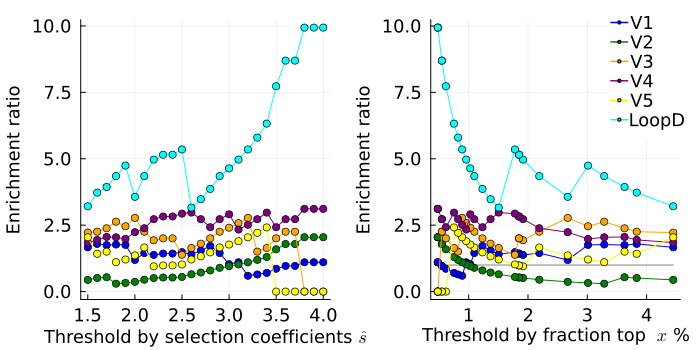

In [163]:
color_set = ["blue", "green", "orange", "purple", "yellow", "cyan"]
p1 = Plots.plot(100*s_threshold_RMs_set, x_fold_V1_set, label="V1", 
    xlabel=L"Threshold by selection coefficients $\hat{s}$", 
    ylabel="Enrichment ratio", 
    foreground_color_legend = nothing,
    c = color_set[1],
    labelfontsize=12,
    legendfontsize=12, 
    m=:circle,
    margin=3mm,
    legend=:false,
    tickfontsize=12,
)
Plots.plot!(100*s_threshold_RMs_set, x_fold_V2_set, label="V2", m=:circle, c = color_set[2])
Plots.plot!(100*s_threshold_RMs_set, x_fold_V3_set, label="V3", m=:circle, c = color_set[3],)
Plots.plot!(100*s_threshold_RMs_set, x_fold_V4_set, label="V4", m=:circle, c = color_set[4],)
Plots.plot!(100*s_threshold_RMs_set, x_fold_V5_set, label="V5", m=:circle, c = color_set[5],)
Plots.plot!(100*s_threshold_RMs_set, x_fold_LoopD_set, label="LoopD", m=:circle, c = color_set[6])

p2 = Plots.plot(100*α_selected_est, ones(size(α_selected_est)), label=:false, c=:gray)
Plots.plot!(100*α_selected_est, x_fold_V1_set, label="V1", 
    xlabel=L"Threshold by fraction top  $x$ %", 
    ylabel="Enrichment ratio", 
    c = color_set[1],
    foreground_color_legend = nothing,
    labelfontsize=12,
    legendfontsize=12, 
    m=:circle,
    tickfontsize=12,
    margin=3mm,
    legend=(0.8, 0.99)
)
Plots.plot!(100*α_selected_est, x_fold_V2_set, label="V2", m=:circle, c = color_set[2],)
Plots.plot!(100*α_selected_est, x_fold_V3_set, label="V3", m=:circle, c = color_set[3],)
Plots.plot!(100*α_selected_est, x_fold_V4_set, label="V4", m=:circle, c = color_set[4],)
Plots.plot!(100*α_selected_est, x_fold_V5_set, label="V5", m=:circle, c = color_set[5],)
Plots.plot!(100*α_selected_est, x_fold_LoopD_set, label="LoopD", m=:circle, c = color_set[6],)

Plots.plot(p1,p2, layout=(1,2), size=(700, 350))
#Plots.savefig("../fig/enrichment_vs_threshold_CH505.pdf")

In [168]:
count(csv_raw_CH505.s_MPL .> 0.030)

15

"/net/dali/home/barton/kais/submission/HIV_Coevolution/note"